In [2]:
import pandas as pd
from ProjectTools import OpenBeds
from ProjectTools.OpenBeds import filterDepth
import numpy as np

dry = True

if dry == True:
    wgbs_bed_path = './test_data/ENCSR893RHD_modifications_mm39_sub.bed'
    tab_bed_path = './test_data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov_sub.bed'
    oxbs_bed_path = './test_data/CRD018546.gz_val_1_bismark_bt2_pe.deduplicated.bedGraph.gz.bismark.zero.cov_sub.bed'

    nano_2mod_path = './test_data/prom_R10.4.1_E8.2_WGS_brain_DH_5mC_nonAggregated_sub.bedMethyl'
    nano_3mod_path = './test_data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods_sub.bed'
    
    nano_mc_df, nano_hmc_df = map(filterDepth, OpenBeds.get_nanopore_threeMod_wStrand(nano_3mod_path))

    nano_2mod_df = filterDepth(OpenBeds.get_nanopore_twoMod(nano_2mod_path))
    wgbs_df = filterDepth(OpenBeds.get_wgbs(wgbs_bed_path))
    tab_df = filterDepth(OpenBeds.get_bismark(tab_bed_path, "5hmC"))
    oxbs_df = filterDepth(OpenBeds.get_bismark(oxbs_bed_path, "5mC"))

else:
    wgbs_bed_path = './data/ENCSR893RHD_modifications_mm39.bed'
    tab_bed_path = './data/TAB_data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov'
    oxbs_bed_path = './data/CRR008808_oxBS_remergedRaw.zero.cov_modified.bed'

    nano_2mod_path = './data/prom_R10.4.1_E8.2_WGS_brain_DH_5mC_nonAggregated.bedMethyl'
    nano_3mod_path = './data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods.bed'

    nano_mc_df, nano_hmc_df = map(filterDepth, OpenBeds.get_nanopore_threeMod_wStrand(nano_3mod_path))

    nano_2mod_df = filterDepth(OpenBeds.get_nanopore_twoMod(nano_2mod_path))
    wgbs_df = filterDepth(OpenBeds.get_wgbs(wgbs_bed_path))
    tab_df = filterDepth(OpenBeds.get_bismark(tab_bed_path, "5hmC"))
    oxbs_df = filterDepth(OpenBeds.get_bismark(oxbs_bed_path, "5mC"))

In [3]:
from scipy import stats

def mergeMethods(bis_df, nano_df):
    bis_df, nano_df = map(lambda df: df.drop(columns=["method", "readCount"]), [bis_df, nano_df])
    wide_merged = pd.merge(
        bis_df, nano_df, "inner", ["chromosome", "chromStart", "chromEnd", "modification_type"], suffixes=["_Bisulphite", "_Nanopore"]
        )
    long_merged = pd.wide_to_long(wide_merged, stubnames=["readCount", "percentMeth"], i=["chromosome", "chromStart", "chromEnd", "modification_type"], 
                                  j="method", sep="_", suffix="\D+")
    return wide_merged.reset_index(drop=True), long_merged.reset_index()

def calcPearson(wide_df):
    x, y = wide_df["percentMeth_Bisulphite"], wide_df["percentMeth_Nanopore"]
    return stats.pearsonr(x, y)

def calcKS(wide_df):
    x, y = wide_df["percentMeth_Bisulphite"], wide_df["percentMeth_Nanopore"]
    return stats.ks_2samp(x, y, method="asymp")

In [4]:
two_mod_wide, two_mod_long = mergeMethods(wgbs_df, nano_2mod_df)
mc_df_wide, mc_df_long  = mergeMethods(oxbs_df, nano_mc_df)
hmc_df_wide, hmc_df_long = mergeMethods(tab_df, nano_hmc_df)

/mnt/data1/doh28/tools/condas/GeneralAnalysis/lib/python3.9/site-packages/seaborn/utils.py:482: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)
/mnt/data1/doh28/tools/condas/GeneralAnalysis/lib/python3.9/site-packages/seaborn/utils.py:482: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)
/mnt/data1/doh28/tools/condas/GeneralAnalysis/lib/python3.9/site-packages/seaborn/utils.py:482: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


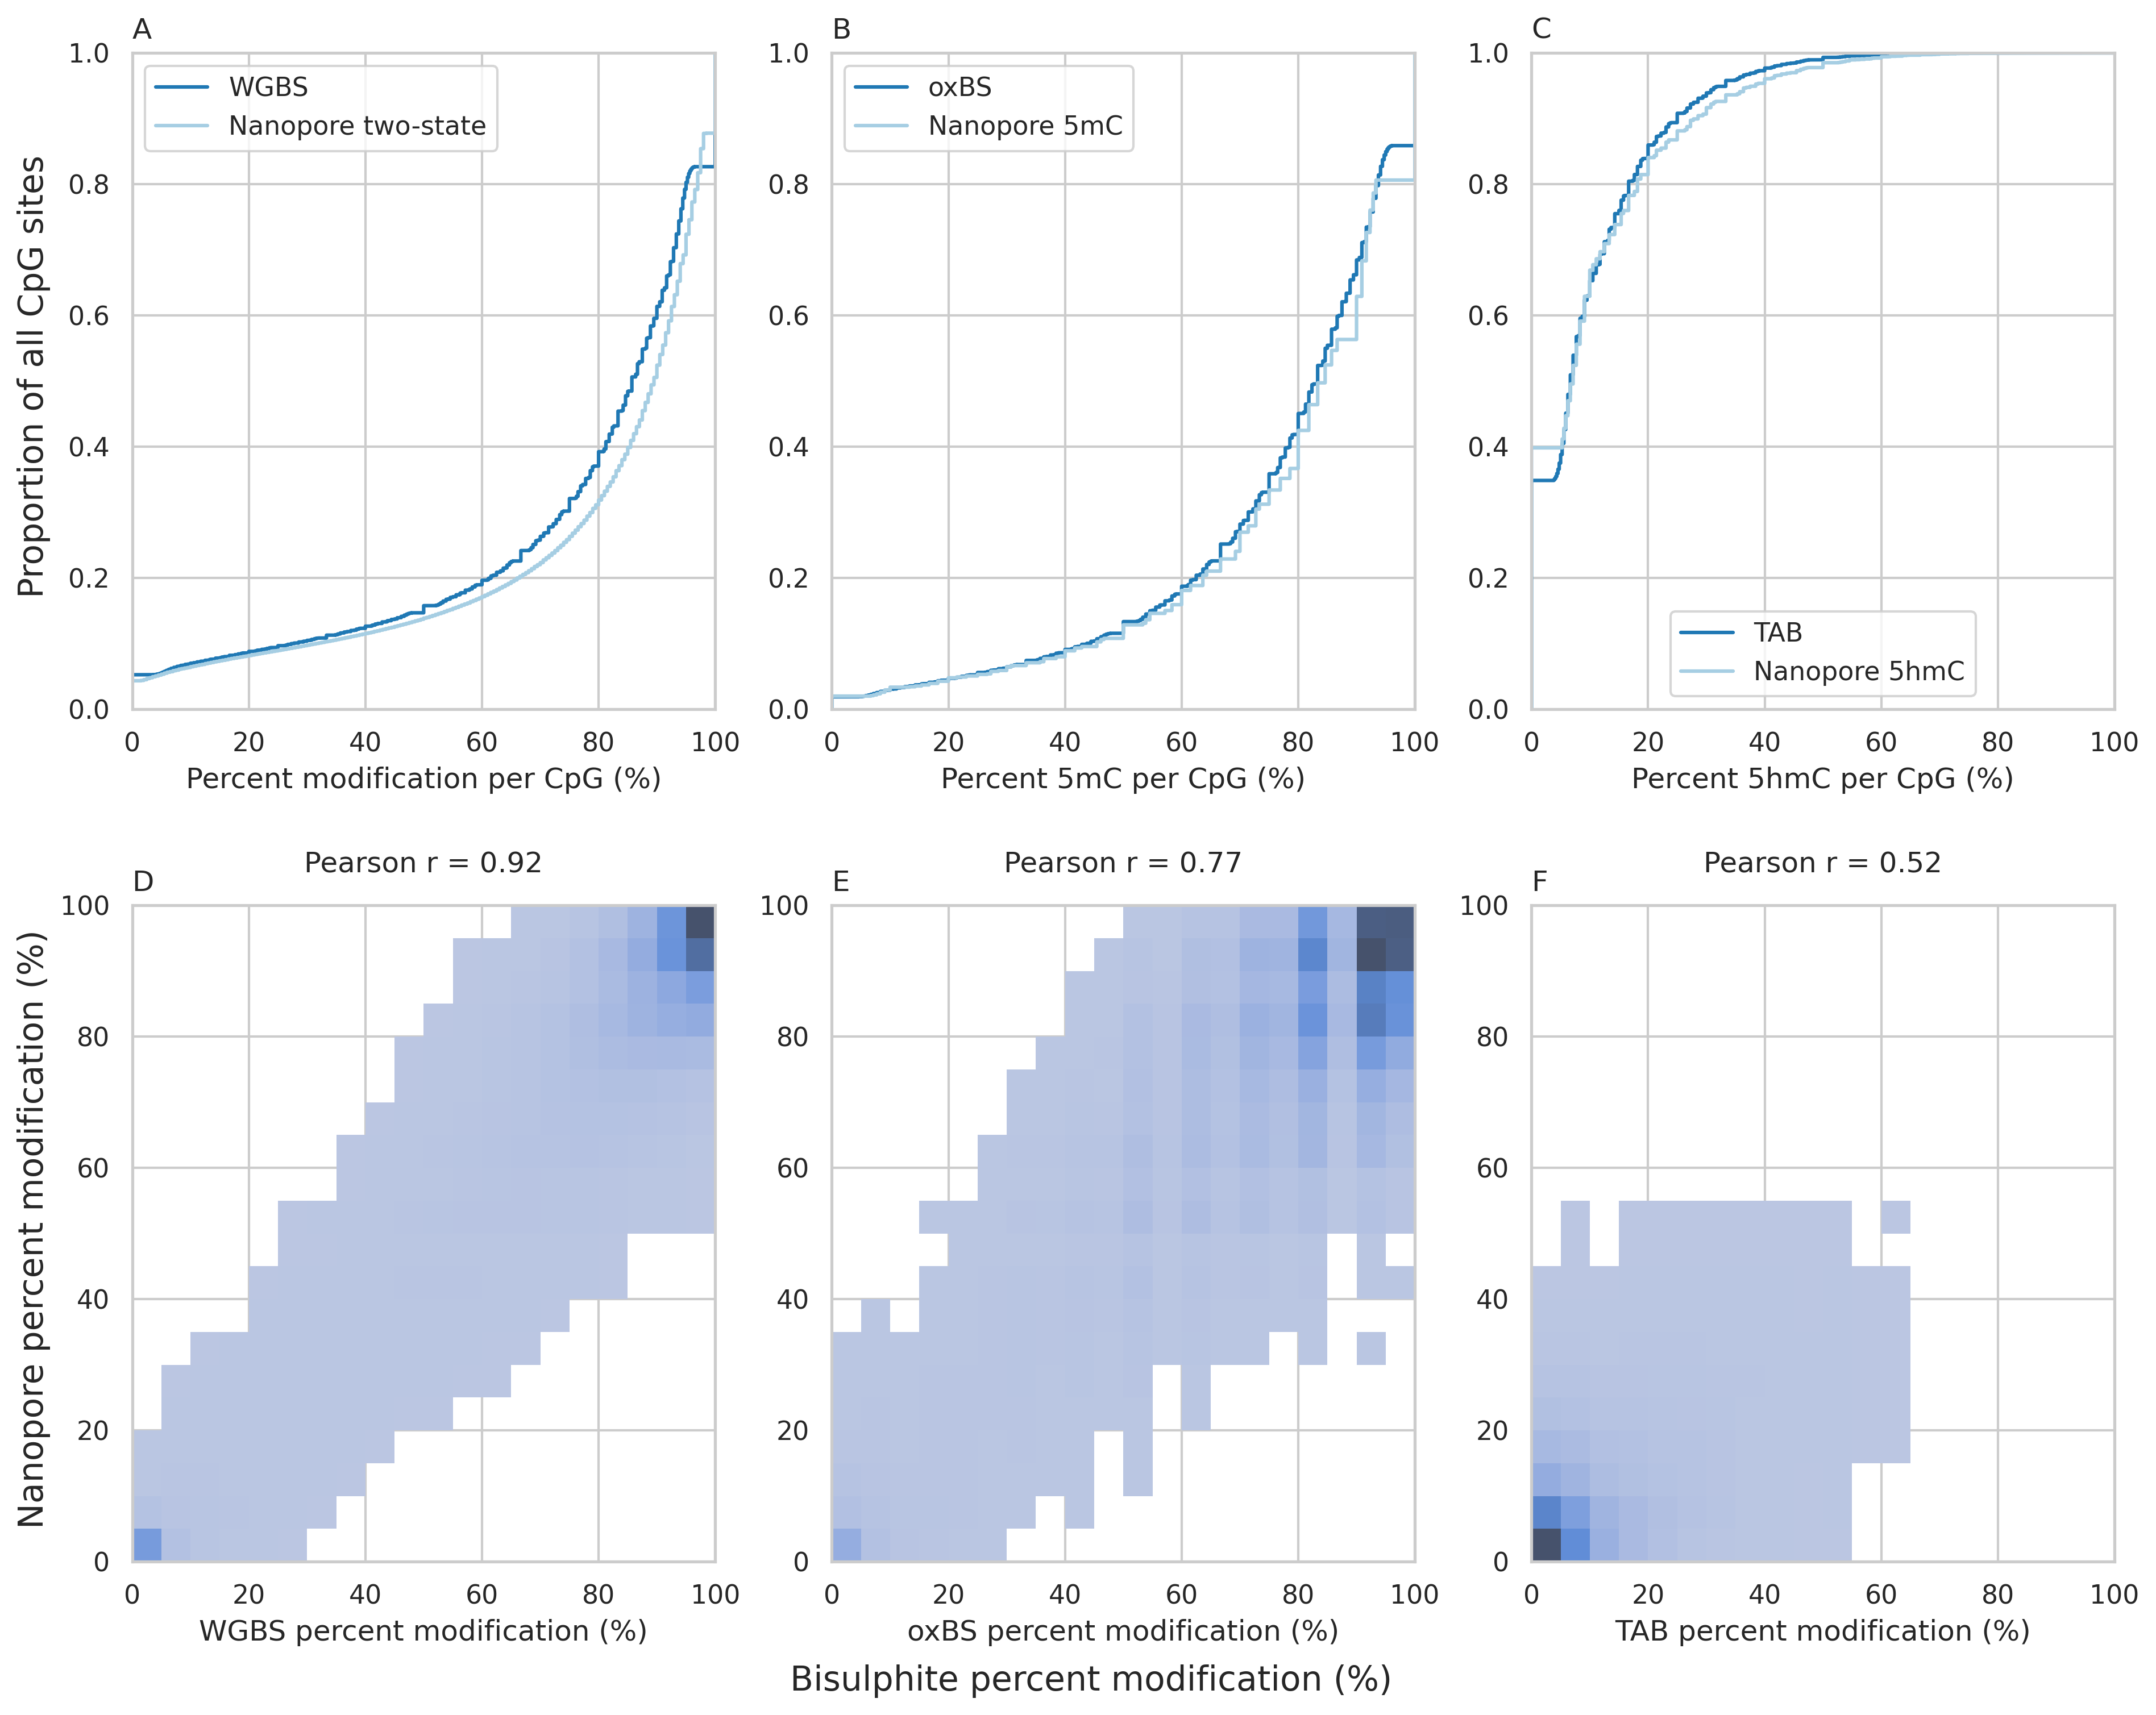

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

sns.set_theme(style="whitegrid")

fig1 = plt.figure(dpi=300, figsize=(15, 10)) 
gs1 = GridSpec(2, 1, fig1)

fig11 = fig1.add_subfigure(gs1[0, :])
gs11 = GridSpec(1, 3, fig11)
fig11.supylabel("Proportion of all CpG sites", x=0.08)

ax11 = fig11.add_subplot(gs11[0, 0])
ax12 = fig11.add_subplot(gs11[0, 1])
ax13 = fig11.add_subplot(gs11[0, 2])

sns.ecdfplot(two_mod_long, x="percentMeth", hue="method", palette="Paired", ax=ax11)
sns.move_legend(ax11, "upper left", title=None, labels=["WGBS", "Nanopore two-state"])
# ax11.text(50, 1.05, "Kolmogorov-Smirnov = {ks:.2f}".format(ks=calcKS(two_mod_wide)[0]), ha="center")
ax11.set_ylabel(None)
ax11.set_xlabel("Percent modification per CpG (%)")
ax11.set_title("A", loc="left")
ax11.set_xlim([0, 100])

sns.ecdfplot(mc_df_long, x="percentMeth", hue="method", palette="Paired", ax=ax12)
sns.move_legend(ax12, "upper left", title=None, labels=["oxBS", "Nanopore 5mC"])
# ax12.text(50, 1.05, "Kolmogorov-Smirnov = {ks:.2f}".format(ks=calcKS(mc_df_wide)[0]), ha="center")
ax12.set_ylabel(None)
ax12.set_xlabel("Percent 5mC per CpG (%)")
ax12.set_title("B", loc="left")
ax12.set_xlim([0, 100])

sns.ecdfplot(hmc_df_long, x="percentMeth", hue="method", palette="Paired", ax=ax13)
sns.move_legend(ax13, "lower center", title=None, labels=["TAB", "Nanopore 5hmC"])
# ax13.text(50, 1.05, "Kolmogorov-Smirnov = {ks:.2f}".format(ks=calcKS(hmc_df_wide)[0]), ha="center")
ax13.set_ylabel(None)
ax13.set_xlabel("Percent 5hmC per CpG (%)")
ax13.set_xlim([0, 100])
ax13.set_title("C", loc="left")

fig12 = fig1.add_subfigure(gs1[1, :])
fig12.supxlabel("Bisulphite percent modification (%)", y=-0.05)
fig12.supylabel("Nanopore percent modification (%)", x=0.08)
gs12 = GridSpec(1, 3, fig12)

ax14 = fig12.add_subplot(gs12[0, 0])
ax15 = fig12.add_subplot(gs12[0, 1])
ax16 = fig12.add_subplot(gs12[0, 2])

sns.histplot(two_mod_wide, x="percentMeth_Bisulphite", y="percentMeth_Nanopore", bins=20, pthresh=0.01, stat="density", ax=ax14)
ax14.text(50, 105, "Pearson r = {r:.2f}".format(r=calcPearson(two_mod_wide)[0]), ha="center")
ax14.set_xlim((0, 100))
ax14.set_ylim((0, 100))
ax14.set_xlabel("WGBS percent modification (%)")
ax14.set_ylabel(None)
ax14.set_title("D", loc="left")

sns.histplot(mc_df_wide, x="percentMeth_Bisulphite", y="percentMeth_Nanopore", bins=20, pthresh=0.01, stat="density", ax=ax15)
ax15.text(50, 105, "Pearson r = {r:.2f}".format(r=calcPearson(mc_df_wide)[0]), ha="center")
ax15.set_xlim((0, 100))
ax15.set_ylim((0, 100))
ax15.set_xlabel("oxBS percent modification (%)")
ax15.set_ylabel(None)
ax15.set_title("E", loc="left")

sns.histplot(hmc_df_wide, x="percentMeth_Bisulphite", y="percentMeth_Nanopore", bins=20, pthresh=0.01, stat="density", ax=ax16)
ax16.text(50, 105, "Pearson r = {r:.2f}".format(r=calcPearson(hmc_df_wide)[0]), ha="center")
ax16.set_xlim((0, 100))
ax16.set_ylim((0, 100))
ax16.set_xlabel("TAB percent modification (%)")
ax16.set_ylabel(None)
ax16.set_title("F", loc="left")

fig1.show()

In [6]:
from sklearn import preprocessing
from sklearn import metrics
import numpy as np
from sklearn.metrics import confusion_matrix

def ROCmain(wide_df, ax, label):

    def ROCbinariser():
        binariser = preprocessing.Binarizer(threshold=50)
        wide_df["binarised"] = binariser.fit_transform(np.reshape(wide_df["percentMeth_Bisulphite"].to_numpy(), (-1, 1)))
        return wide_df

    def ROC():
        binarised_df = ROCbinariser()
        fpr, tpr, threshold = metrics.roc_curve(binarised_df["binarised"], binarised_df["percentMeth_Nanopore"])
        return fpr, tpr
    
    def plotROC(ax, label):
        fpr, tpr = ROC()
        return ax.plot(fpr, tpr, "-", label=label, lw=2)

    return plotROC(ax, label)

def merge3Mod(): 
    mc_df, hmc_df = map(lambda df: df.drop(columns=["modification_type"]), [mc_df_wide, hmc_df_wide])
    merged_df = pd.merge(mc_df, hmc_df, "inner", ["chromosome", "chromStart", "chromEnd"], suffixes=["_5mC", "_5hmC"])
    return merged_df
    
def defineTruthset():
    truth_list = np.select(
        [merge3Mod()["percentMeth_Bisulphite_5hmC"].gt(50), 
         merge3Mod()["percentMeth_Bisulphite_5mC"].gt(50)],
         ["5hmC", "5mC"], default="C")
    return truth_list

def definePredictions():
    prediction_list = np.select(
        [merge3Mod()["percentMeth_Nanopore_5hmC"].gt(50), 
         merge3Mod()["percentMeth_Nanopore_5mC"].gt(50)],
         ["5hmC", "5mC"], default="C")
    return prediction_list
    
def binBenchmark(wide_df):
    wide_df["bin"] = pd.cut(wide_df["percentMeth_Bisulphite"], 51, labels=np.arange(0, 102, 2))
    return wide_df

def calcChiSquare(wide_df):
    x = pd.cut(wide_df["percentMeth_Bisulphite"], 21, labels=np.arange(0, 105, 5)).value_counts()
    y = pd.cut(wide_df["percentMeth_Nanopore"], 21, labels=np.arange(0, 105, 5)).value_counts()
    return stats.chisquare(x, y)

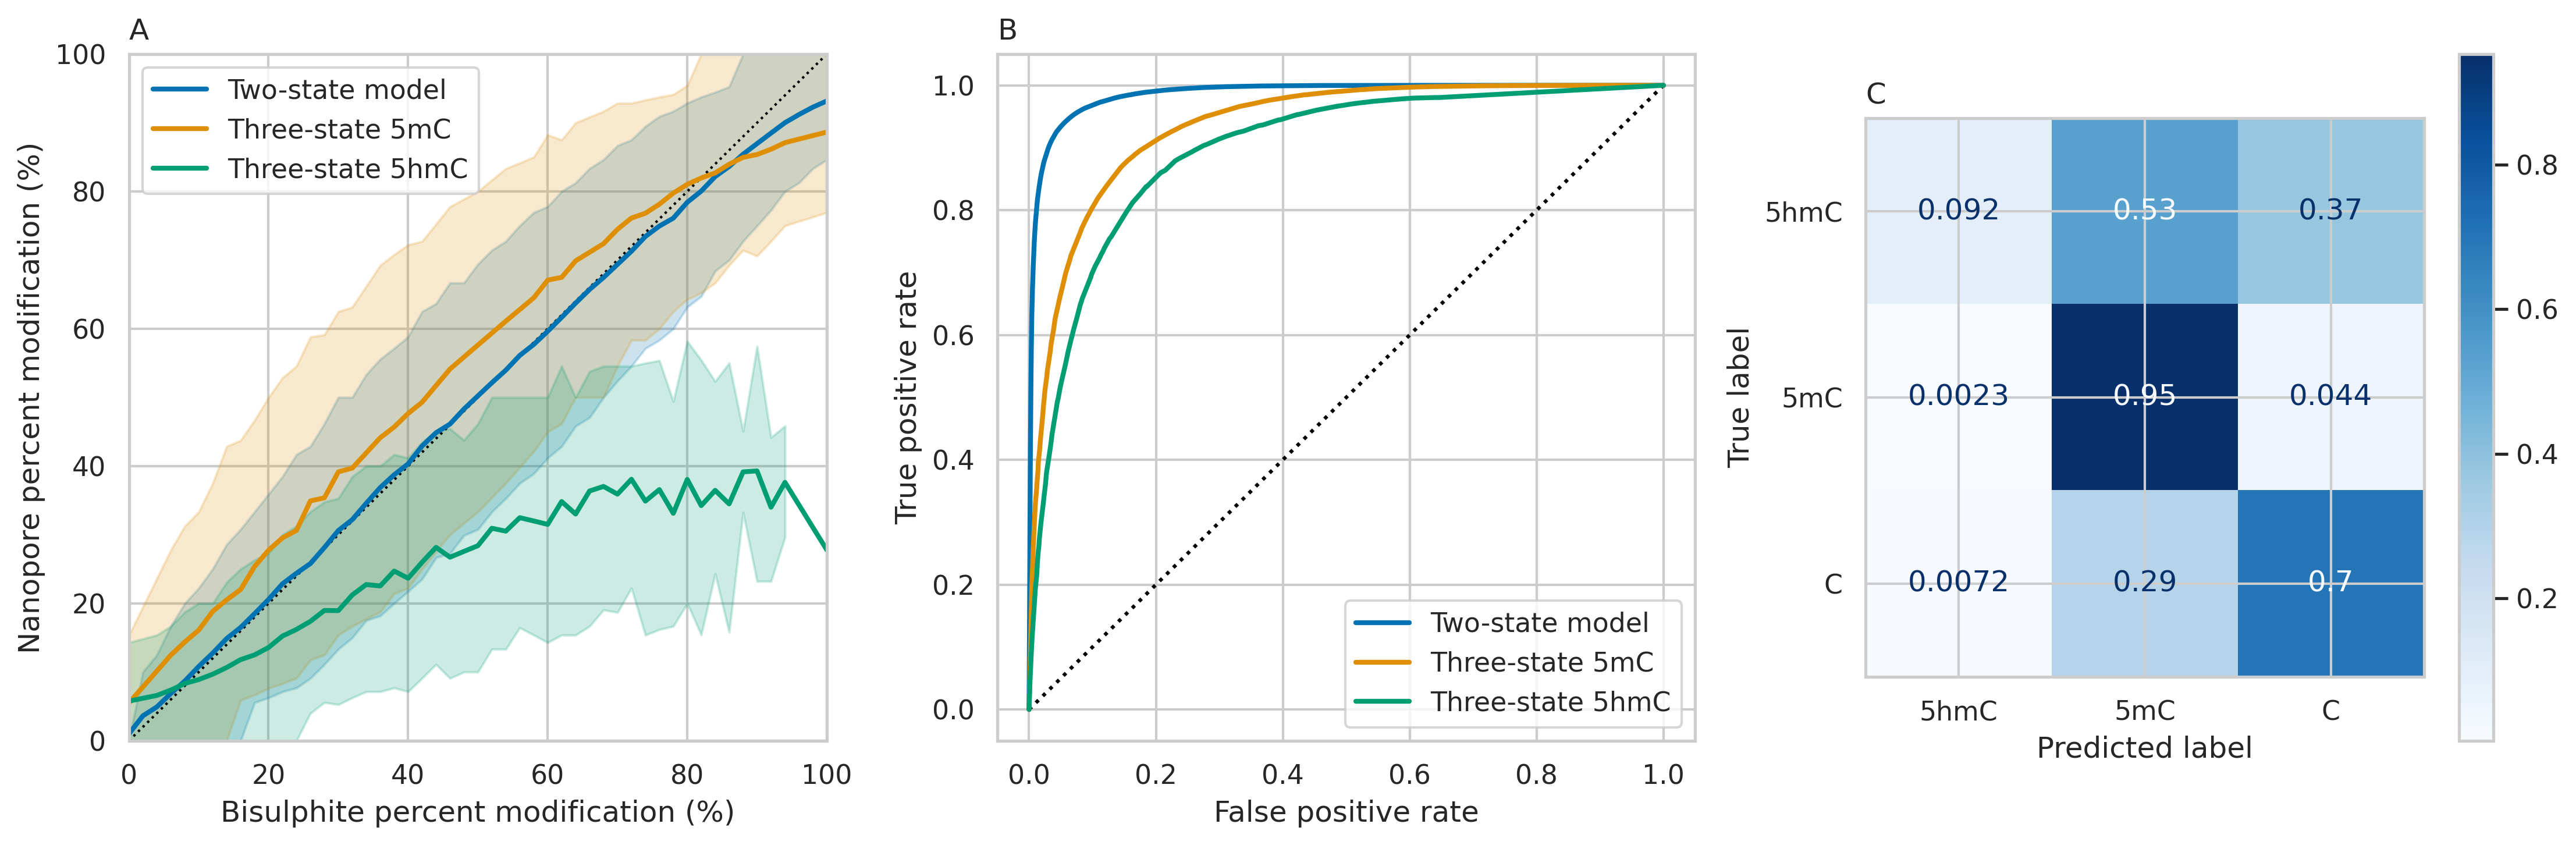

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.metrics import ConfusionMatrixDisplay

sns.set_theme(style="whitegrid")
sns.set_palette("colorblind")

fig2 = plt.figure(dpi=300, figsize=(15, 5)) 
gs2 = GridSpec(1, 3, fig2)

ax21 = fig2.add_subplot(gs2[0, 0])
ax21.plot(np.arange(0, 105, 5), np.arange(0, 105, 5), linestyle=":", lw=1, color="black")
sns.lineplot(binBenchmark(two_mod_wide), x="bin", y="percentMeth_Nanopore", errorbar=("pi", 75), err_style="band", label="Two-state model", linewidth=2, ax=ax21)
sns.lineplot(binBenchmark(mc_df_wide), x="bin", y="percentMeth_Nanopore", errorbar=("pi", 75), err_style="band", label="Three-state 5mC", linewidth=2, ax=ax21)
sns.lineplot(binBenchmark(hmc_df_wide), x="bin", y="percentMeth_Nanopore", errorbar=("pi", 75), err_style="band", label="Three-state 5hmC", linewidth=2, ax=ax21)
ax21.legend()
sns.move_legend(ax21, "upper left")
ax21.set_ylim((0, 100))
ax21.set_xlim((0, 100))
ax21.set_xlabel("Bisulphite percent modification (%)")
ax21.set_ylabel("Nanopore percent modification (%)")
ax21.set_title("A", loc="left")

ax24 = fig2.add_subplot(gs2[0, 1])
ax24.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), "black", linestyle=":")
ROCmain(two_mod_wide, ax24, "Two-state model")
ROCmain(mc_df_wide, ax24, "Three-state 5mC")
ROCmain(hmc_df_wide, ax24, "Three-state 5hmC")
ax24.set_xlabel("False positive rate")
ax24.set_ylabel("True positive rate")
ax24.legend()
sns.move_legend(ax24, "lower right")
ax24.set_title("B", loc="left")

ax25 = fig2.add_subplot(gs2[0, 2])
ConfusionMatrixDisplay.from_predictions(defineTruthset(), definePredictions(), normalize="true", cmap="Blues", ax=ax25)
ax25.set_title("C", loc="left")

fig2.tight_layout()

In [8]:
test = merge3Mod()
nanopore_mean = np.mean(test["percentMeth_Nanopore_5hmC"])
bisulphite_mean = np.mean(test["percentMeth_Bisulphite_5hmC"])

with np.errstate(divide="ignore"):
    test["hmCtoMean_Nanopore"] = np.log2(
        np.divide(test["percentMeth_Nanopore_5hmC"], 
                  nanopore_mean)
    )
    test["hmCtoMean_Bisulphite"] = np.log2(
        np.divide(test["percentMeth_Bisulphite_5hmC"], 
                  bisulphite_mean)
    )
test = test.replace(-np.inf, np.NaN).dropna().reset_index()

In [9]:
x, y = test["hmCtoMean_Bisulphite"], test["hmCtoMean_Nanopore"]
stats.pearsonr(x, y)


PearsonRResult(statistic=0.38949291422281224, pvalue=0.0)

In [10]:
stats.spearmanr(x, y)

SignificanceResult(statistic=0.3565070154082032, pvalue=0.0)

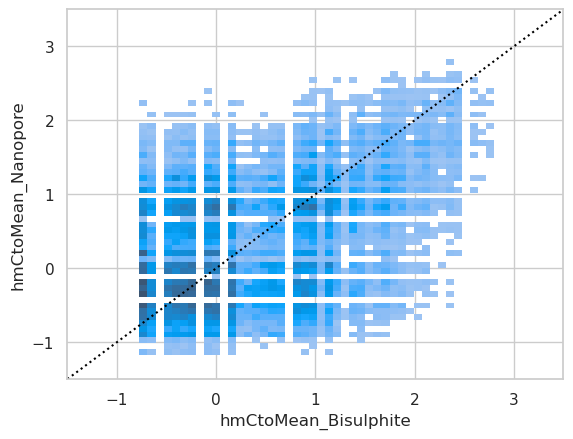

In [11]:
fig, ax = plt.subplots()
ax.set_ylim((-1.5, 3.5))
ax.set_xlim((-1.5, 3.5))
sns.histplot(test, x=test["hmCtoMean_Bisulphite"], y=test["hmCtoMean_Nanopore"], pthresh=0.05)
ax.plot(np.arange(-1.5, 4.5, 1), np.arange(-1.5, 4.5, 1), color="black", linestyle=":")

In [17]:
import pyranges as pr
import subprocess

def threeModDFtoPyrange():
    data = merge3Mod()

    pyrange = pr.from_dict({
        "Chromosome" : data["chromosome"],
        "Start" : data["chromStart"],
        "End" : data["chromEnd"],
        "Strand" : data["strand_5hmC"],
        "percentMeth_Nanopore_5hmC" : data["percentMeth_Nanopore_5hmC"], 
        "percentMeth_Bisulphite_5hmC" : data["percentMeth_Bisulphite_5hmC"]
        }
        )
    return pyrange

def intersectWithGene():
    pyrange = threeModDFtoPyrange()
    gene_ref = pd.read_csv('./feature_references/revised/GENCODE_Basic_mm39_Genes_merged.bed', sep="\t", 
                           names=["Chromosome", "Start", "End", "geneName", "Strand"])    
    return pyrange.join(pr.PyRanges(gene_ref), strandedness="same")

def convertToGeneDF():
    pyrange = intersectWithGene()
    gene_df = pyrange.as_df().groupby(["geneName"])[["percentMeth_Nanopore_5hmC", "percentMeth_Bisulphite_5hmC"]].agg([np.mean, "count"])
    return gene_df.reset_index()

def log2MeanDF():
    gene_df = convertToGeneDF()
    nanopore_mean = np.mean(gene_df["percentMeth_Nanopore_5hmC"]["mean"])
    bisulphite_mean = np.mean(gene_df["percentMeth_Bisulphite_5hmC"]["mean"])

    with np.errstate(divide="ignore"):
        gene_df["Log2FromMean_Nanopore"] = np.log2(
            np.divide(gene_df["percentMeth_Nanopore_5hmC"]["mean"],
                    nanopore_mean)
        )
        gene_df["Log2FromMean_Bisulphite"] = np.log2(
            np.divide(gene_df["percentMeth_Bisulphite_5hmC"]["mean"],
                    bisulphite_mean)
        )
    gene_df = gene_df.replace(-np.inf, np.nan)
    return gene_df.dropna()    

def findClosest():
    gene_df = log2MeanDF()
    gene_df["Difference"] = np.abs(
        np.subtract(gene_df["Log2FromMean_Bisulphite"], gene_df["Log2FromMean_Nanopore"])
    )
    gene_df = gene_df.sort_values("Difference")
    return gene_df

def makeRefDF(path, feature_type):
    columns = ["Chromosome","Start","End","Name","Score","Strand","feature_type"]
    df = pd.read_csv(path, sep="\t", names=columns)
    df["feature_type"] = feature_type
    return df

def makeFeatureRefDF():
    gene_feature_list = subprocess.check_output(["ls", "./feature_references/revised/gene_features/"]).decode("utf-8").split("\n") 
    gene_feature_list.pop(-1)

    df_list = []
    for file in gene_feature_list:
        path = "./feature_references/revised/gene_features/" + file
        columns = ["Chromosome","Start","End","Name","Score","Strand"]
        df = pd.read_csv(path, sep="\t", names=columns)
        df["feature_type"] = file.split("_")[3]
        df_list.append(df)

    feature_reference_df = pd.concat(df_list)
    return feature_reference_df

def makeCGIrefDF():
    cgi_feature_list = subprocess.check_output(["ls", "./feature_references/revised/cgi/"]).decode("utf-8").split("\n") 
    cgi_feature_list.pop(-1)

    cgi_df_list = []
    for file in cgi_feature_list:
        path = "./feature_references/revised/cgi/" + file
        columns = ["Chromosome","Start","End","Name","feature_type"]
        df = pd.read_csv(path, sep="\t", names=columns)
        cgi_df_list.append(df)

    cgi_reference_df = pd.concat(cgi_df_list)
    return cgi_reference_df

def meltMethod(input_df):
    df_melt = input_df.melt(
        ["Chromosome", "Start", "End", "Strand", "feature_type"], 
        ["percentMeth_Nanopore_5hmC", "percentMeth_Bisulphite_5hmC"], 
        "method", 
        value_name="percentMeth"
                    )
    return df_melt

def replaceMethod(input_df):
    df_with_replacement = input_df.replace(["percentMeth_Nanopore_5hmC", "percentMeth_Bisulphite_5hmC"], ["Nanopore 5hmC", "TAB"])
    return df_with_replacement

def categoriseGeneFeatures(input_df):
    categorised_features = input_df.copy()
    categorised_features["feature_type"] = pd.Categorical(
        categorised_features["feature_type"], 
        ["Intergenic", "Promoter", "5UTR", "Intron", "Exon", "3UTR"])
    return categorised_features
        
def categoriseCGI(input_df):
    categorised_features = input_df.copy()
    categorised_features["feature_type"] = pd.Categorical(
        categorised_features["feature_type"], ["Open sea", "Upstream shelf", "Upstream shore", "CGI", "Downstream shore", "Downstream shelf"])
    return categorised_features
        
def intersectWithFeatures(input_df, categorise=None):

    if categorise == "Gene features":
        ref_features = pr.PyRanges(makeFeatureRefDF())
        feature_intersect = input_df.join(ref_features)
        feature_intersect_df = meltMethod(feature_intersect.as_df())
        feature_intersect_df = replaceMethod(feature_intersect_df)
        feature_intersect_df = categoriseGeneFeatures(feature_intersect_df)

    elif categorise == "CGI":
        ref_features = pr.PyRanges(makeCGIrefDF())
        feature_intersect = input_df.join(ref_features)
        feature_intersect_df = meltMethod(feature_intersect.as_df())
        feature_intersect_df = replaceMethod(feature_intersect_df)
        feature_intersect_df = categoriseCGI(feature_intersect_df)

    return feature_intersect_df

def featureLinePlotMain():
    input_df = threeModDFtoPyrange()
    output_df = intersectWithFeatures(input_df, "Gene features")

    return output_df

def cgiLinePlotMain():
    input_df = threeModDFtoPyrange()
    output_df = intersectWithFeatures(input_df, "CGI")

    return output_df

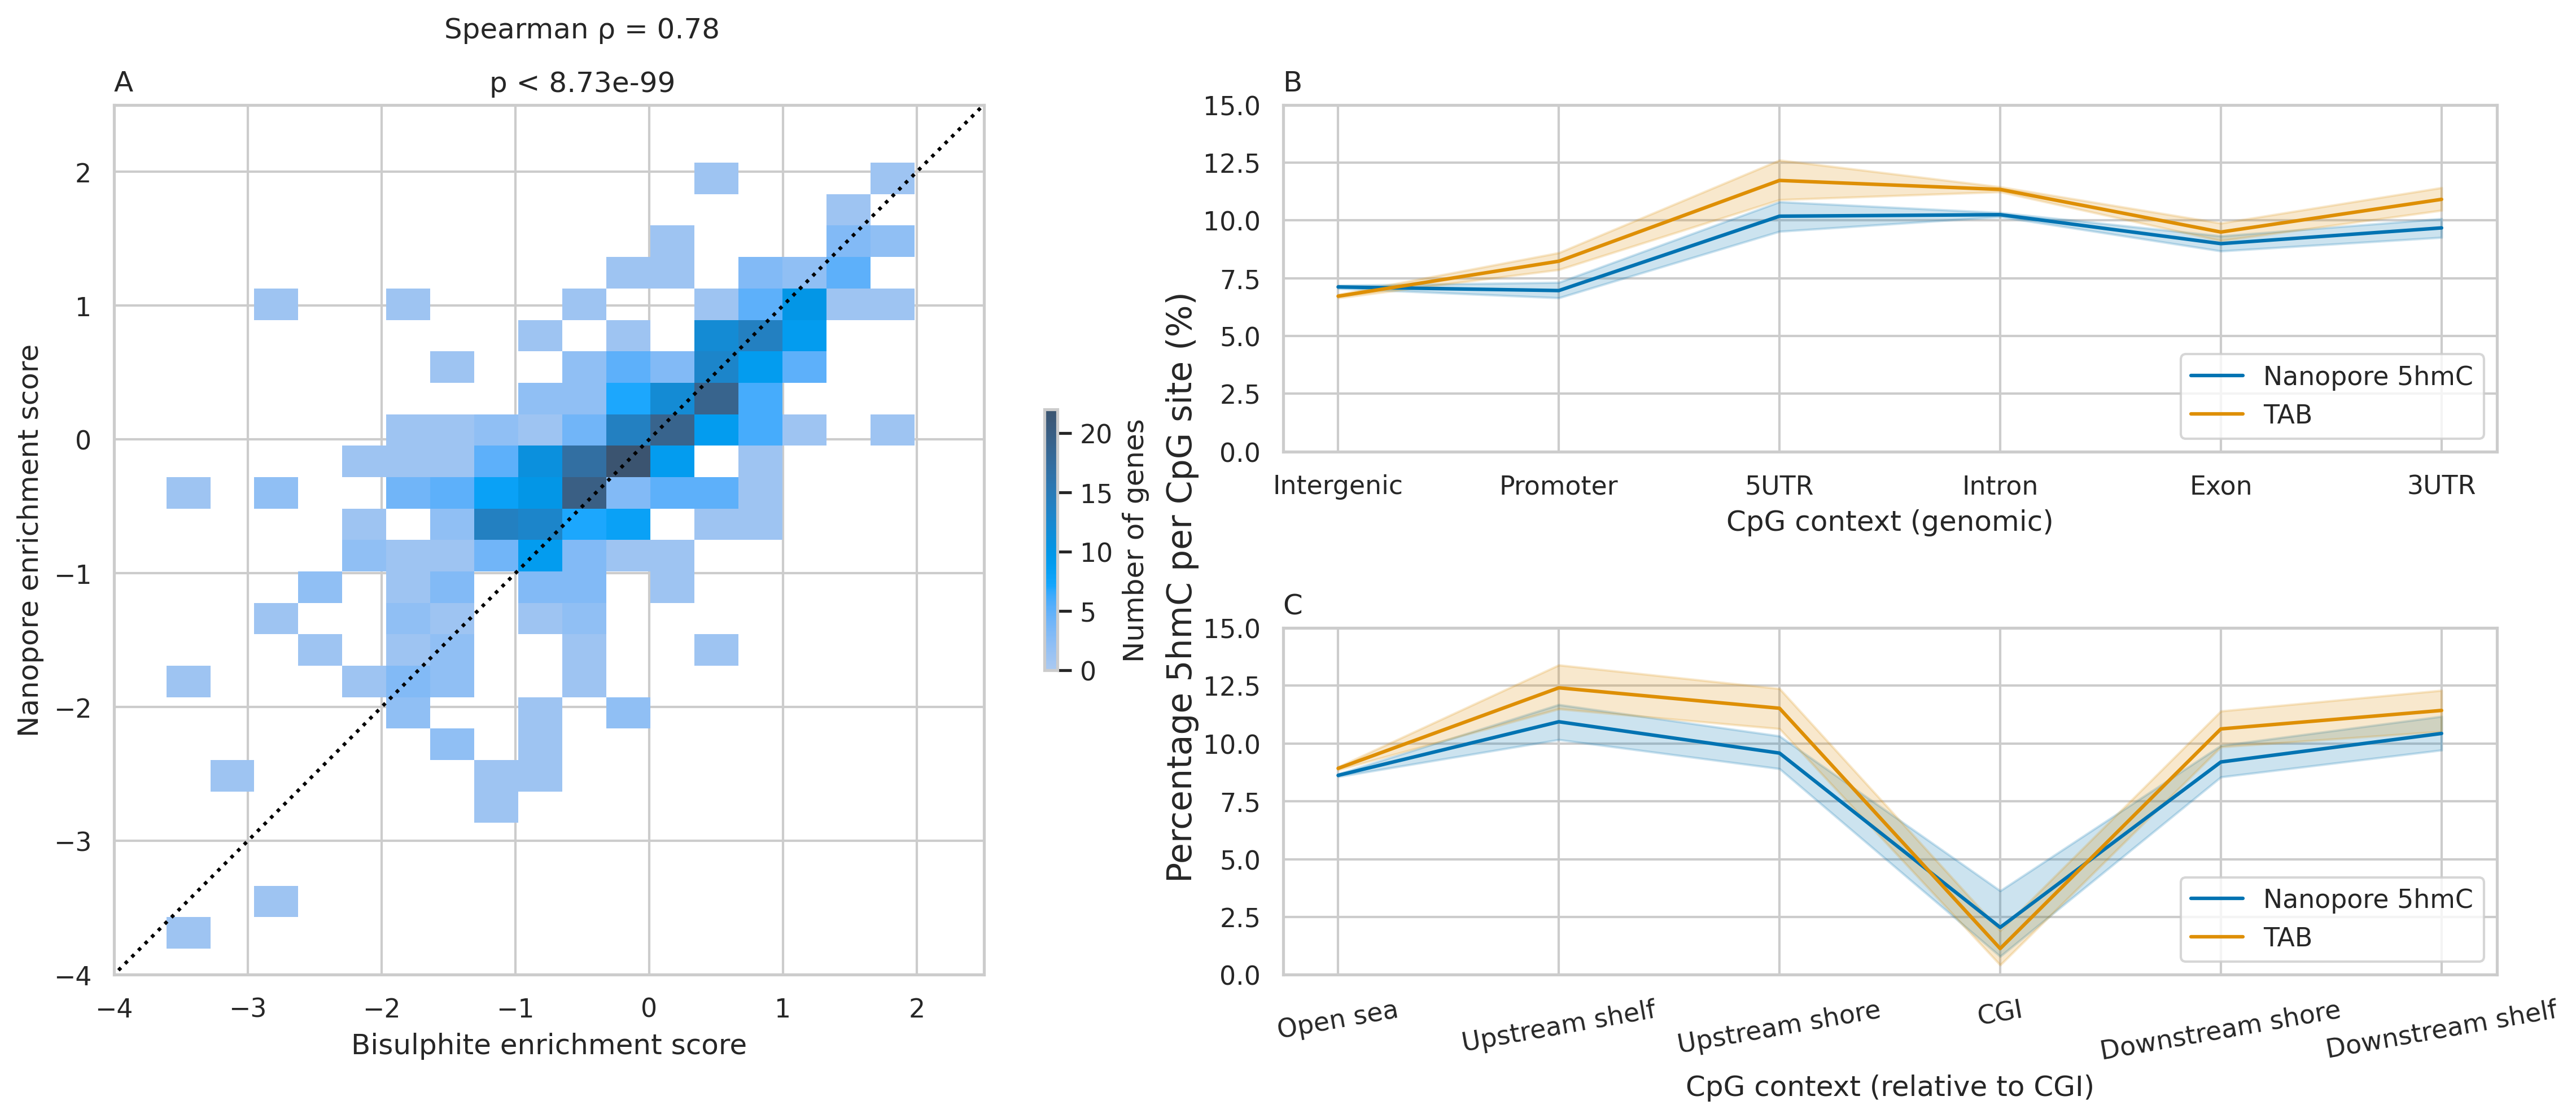

In [18]:
fig3 = plt.figure(dpi=300, figsize=(15, 7))
gs3 = GridSpec(1, 2, fig3)

fig31 = fig3.add_subfigure(gs3[:, 0])
ax31 = fig31.add_subplot()
sns.histplot(log2MeanDF(), x="Log2FromMean_Bisulphite", y="Log2FromMean_Nanopore", cbar=True, stat="count",
             cbar_kws={"label" : "Number of genes", 
                       "format" : "%d",
                       "shrink" : 0.3},
                       ax=ax31
             )
ax31.plot(np.arange(-5, 4, 1), np.arange(-5, 4, 1), color="black", linestyle=":")
# sns.scatterplot(findClosest().head(10).sort_values("Log2FromMean_Bisulphite", ascending=False), 
#            x="Log2FromMean_Bisulphite", y="Log2FromMean_Nanopore", color="red")
ax31.set_aspect(1)
ax31.set_ylim((-4, 2.5))
ax31.set_xlim((-4, 2.5))
ax31.set_xlabel("Bisulphite enrichment score")
ax31.set_ylabel("Nanopore enrichment score")
ax31.set_title("A", loc="left")

gene_rho, gene_p = stats.spearmanr(log2MeanDF()["Log2FromMean_Nanopore"], log2MeanDF()["Log2FromMean_Bisulphite"])
ax31.text(-0.5, 3, "Spearman \u03C1 = {rho:.2f}".format(rho=gene_rho), ha="center")
ax31.text(-0.5, 2.6, "p < {p:.2e}".format(p=gene_p), ha="center")

fig32 = fig3.add_subfigure(gs3[0, 1])
fig32.supylabel("Percentage 5hmC per CpG site (%)", x=-0.07)
gs32 = GridSpec(2, 1, fig32)

ax32 = fig32.add_subplot(gs32[0, :])

sns.lineplot(featureLinePlotMain(), x="feature_type", y="percentMeth", hue="method", err_style="band", ax=ax32)
ax32.set_xlabel("CpG context (genomic)")
ax32.set_ylabel(None)
ax32.set_ylim((0, 15))
ax32.set_title("B", loc="left")
sns.move_legend(ax32, "lower right", title=None)

ax33 = fig32.add_subplot(gs32[1, :])

sns.lineplot(cgiLinePlotMain(), x="feature_type", y="percentMeth", hue="method", err_style="band", ax=ax33)
ax33.set_xlabel("CpG context (relative to CGI)")
ax33.set_ylabel(None)
ax33.set_ylim((0, 15))
ax33.set_title("C", loc="left")
ax33.tick_params("x", rotation=10)
sns.move_legend(ax33, "lower right", title=None)

fig3.tight_layout(pad=2)

In [ ]:
import pyBigWig # required for bigWig output of pr 

def makeChromSizes():
    init = pd.read_csv('./feature_references/revised/mm39.chrom.sizes', sep="\t", names=["Chromosome", "End", "Start"])
    init["Start"] = 0
    init = init[["Chromosome", "Start", "End"]]
    return pr.PyRanges(init).sort()

threeModDFtoPyrange().to_bigwig('./outputs/nanopore_5hmC_chr1.bw', chromosome_sizes=makeChromSizes(), value_col="percentMeth_Nanopore_5hmC")

In [ ]:
findClosest().head(10).sort_values("Log2FromMean_Bisulphite", ascending=False)

geneName   
                                                         
234          ENSMUST00000087435.7,ENSMUST00000194136.2  \
191                              ENSMUST00000061334.10   
260          ENSMUST00000095014.8,ENSMUST00000186694.7   
418                               ENSMUST00000190863.2   
446                               ENSMUST00000193614.2   
28                                ENSMUST00000027062.7   
8    ENSMUST00000010597.10,ENSMUST00000184898.3,ENS...   
364                               ENSMUST00000185283.2   
297  ENSMUST00000127328.2,ENSMUST00000149914.2,ENSM...   
350  ENSMUST00000176154.3,ENSMUST00000177136.4,ENSM...   

    percentMeth_Nanopore_5hmC       percentMeth_Bisulphite_5hmC         
                         mean count                        mean count   
234                 19.447353    68                   21.757548    68  \
191                 17.592857    21                   19.515394    21   
260                 14.692353    34                   16.399646    34   
418                 14.252245    98                   15.885326    98   
446                 12.963333     3                   14.444444     3   
28                   9.712500     4                   10.833333     4   
8                    8.868846    26                    9.943765    26   
364                  7.690000     2                    8.571429     2   
297                  7.357200    25                    8.141925    25   
350                  7.092500   112                    7.975319   112   

    Log2FromMean_Nanopore Log2FromMean_Bisulphite Difference  
                                                              
234              1.082667                1.085900   0.003234  
191              0.938083                0.928997   0.009086  
260              0.678158                0.678049   0.000109  
418              0.634282                0.632079   0.002203  
446              0.497530                0.494899   0.002631  
28               0.081007                0.079861   0.001146  
8               -0.050089               -0.043752   0.006337  
364             -0.255852               -0.258008   0.002157  
297             -0.319679               -0.332174   0.012496  
350             -0.372541               -0.362002   0.010539